In [5]:
import numpy
from scipy import signal

from wfdb import Annotation


def resample_ann(tt, annsamp):
    result = numpy.zeros(len(tt), dtype='bool')
    j = 0
    tprec = tt[j]
    for i, v in enumerate(annsamp):
        while True:
            d = False
            if j+1 == len(tt):
                result[j] = 1
                break
            tnow = tt[j+1]
            if tprec <= v and v <= tnow:
                if v-tprec < tnow-v:
                    result[j] = 1
                else:
                    result[j+1] = 1
                d = True
            j += 1
            tprec = tnow
            if d:
                break
    return numpy.where(result==1)[0].astype('int64')


def resample_sig(x, fs, fs_target):
    t = numpy.arange(x.shape[0]).astype('float64')
    
    if fs == fs_target:
        return x, t
    
    new_length = int(x.shape[0]*fs_target/fs)
    xx, tt = signal.resample(x, num=new_length, t=t)
    assert xx.shape == tt.shape and xx.shape[0] == new_length
    assert numpy.all(numpy.diff(tt) > 0)
    return xx, tt


def resample_singlechan(x, ann, fs, fs_target):
    xx, tt = resample_sig(x, fs, fs_target)
    
    new_annsamp = resample_ann(tt, ann.annsamp)
    assert ann.annsamp.shape == new_annsamp.shape
    
    new_ann = Annotation(ann.recordname, ann.annotator, new_annsamp, ann.anntype, ann.num, ann.subtype, ann.chan, ann.aux, ann.fs)
    return xx, new_ann


def resample_multichan(xs, ann, fs, fs_target, resamp_ann_chan=0):
    # resample_ann_channel is the signal channel that is used to compute new annotation indexes
    assert resamp_ann_chan < xs.shape[1]
    
    lx = []
    lt = None
    for chan in range(xs.shape[1]):
        xx, tt = resample_sig(xs[:, chan], fs, fs_target)
        lx.append(xx)
        if chan == resamp_ann_chan:
            lt = tt
    
    new_annsamp = resample_ann(lt, ann.annsamp)
    assert ann.annsamp.shape == new_annsamp.shape
    
    new_ann = Annotation(ann.recordname, ann.annotator, new_annsamp, ann.anntype, ann.num, ann.subtype, ann.chan, ann.aux, ann.fs)
    return numpy.column_stack(lx), new_ann


def normalize(x, lb=0, ub=1):
    mid = ub - (ub - lb) / 2
    min_v = numpy.min(x)
    max_v = numpy.max(x)
    mid_v =  max_v - (max_v - min_v) / 2
    coef = (ub - lb) / (max_v - min_v)
    return x * coef - (mid_v * coef) + mid


def to_flat(annsamp, size):
    y = numpy.zeros(size, dtype='bool')
    y[annsamp] = 1
    return y

data/mitdb/100 resampling...annsamp 2274
It took 7.294745683670044 s


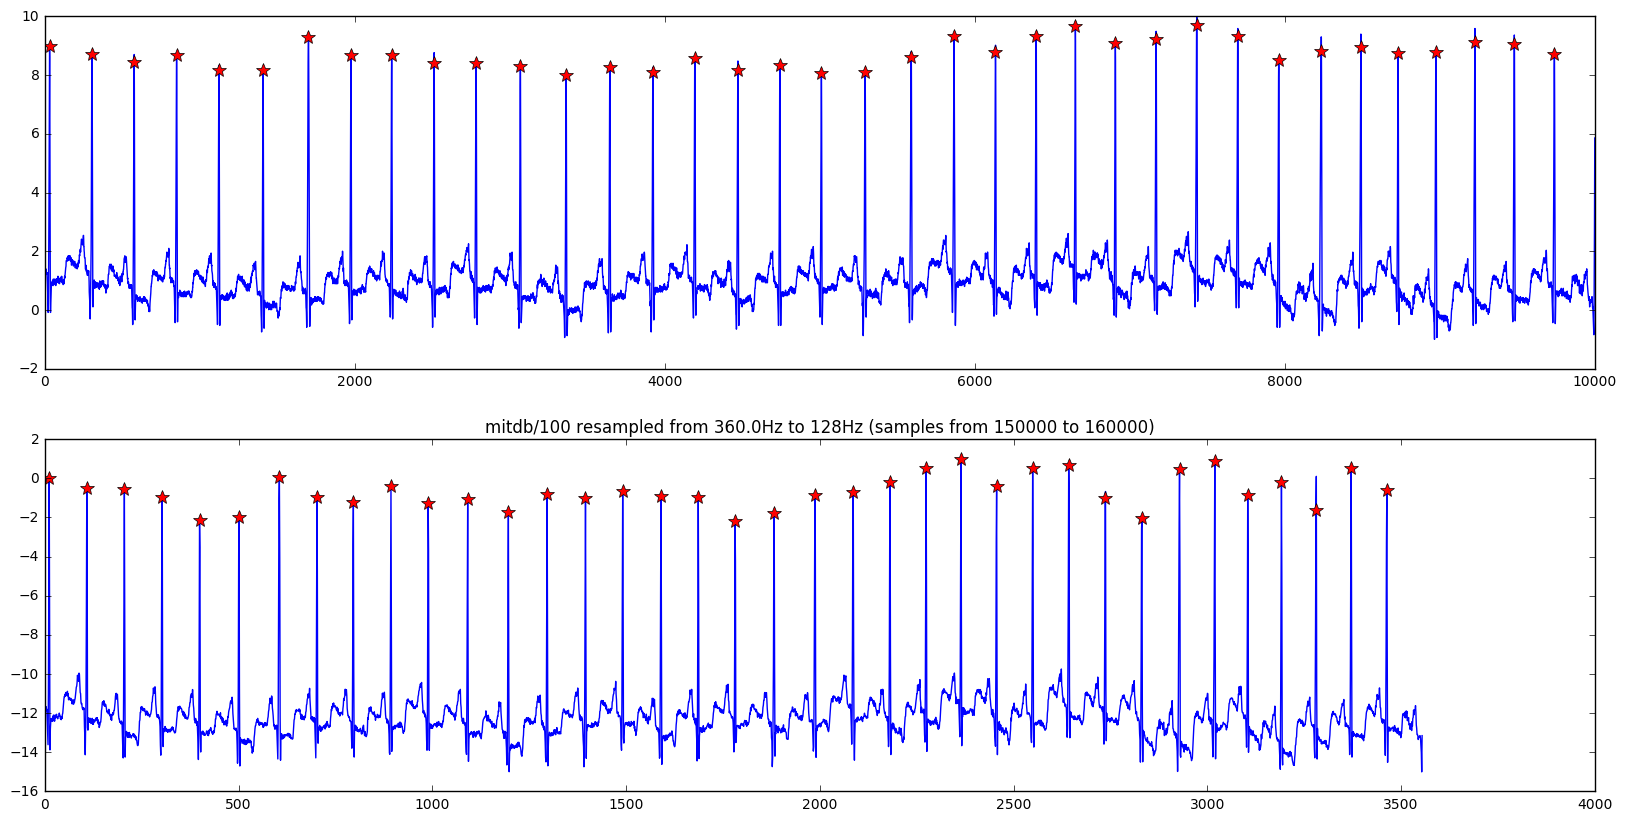

In [6]:
import wfdb

f = 'data/edb/100'
fs_target = 128

sig, fields = wfdb.srdsamp(f)
fs = fields['fs']
ann = wfdb.rdann(f, 'atr')
print(f, 'resampling...', end='')
print('annsamp', len(ann.annsamp))
import time

t1 = time.time()
new_sig, new_ann = resample_multichan(sig, ann, fs, fs_target)
print('It took', time.time()-t1, 's')


import matplotlib as mpl
import matplotlib.pyplot as plt

lb = 150000
ub = 160000
new_lb = int(lb*fs_target/fs)
new_ub = int(ub*fs_target/fs)

plt.figure(1, figsize=(20, 10))
plt.subplot(211)
x = normalize(sig[:, 0][lb:ub], -1, 10)
a = ann.annsamp[numpy.where(numpy.logical_and(lb<=ann.annsamp, ann.annsamp<ub))]-lb
plt.plot(x, 'b-')
plt.plot(a, x[a], 'r*', markersize=10)
plt.subplot(212)
x = normalize(new_sig[:, 0][new_lb:new_ub], -15, 1)
a = new_ann.annsamp[numpy.where(numpy.logical_and(new_lb<=new_ann.annsamp, new_ann.annsamp<new_ub))]-new_lb
plt.plot(x, 'b-')
plt.plot(a, x[a], 'r*', markersize=10)
plt.title('mitdb/100 resampled from {}Hz to {}Hz (samples from {} to {})'.format(fs, fs_target, lb, ub))
plt.show()

In [53]:
tttt = [numpy.random.rand(10), numpy.random.rand(10), numpy.random.rand(10)]
print(tttt)
numpy.column_stack(tttt)

[array([ 0.81233151,  0.9975441 ,  0.75268665,  0.02750908,  0.45940587,
        0.76111496,  0.43381409,  0.80045675,  0.49396378,  0.25886425]), array([ 0.71797293,  0.21264999,  0.47883097,  0.73535084,  0.38882432,
        0.57081617,  0.04118389,  0.93669742,  0.37796356,  0.04174497]), array([ 0.10932598,  0.48702598,  0.36976685,  0.63053229,  0.97972965,
        0.58246286,  0.63824648,  0.57621345,  0.16005438,  0.13366341])]


array([[ 0.81233151,  0.71797293,  0.10932598],
       [ 0.9975441 ,  0.21264999,  0.48702598],
       [ 0.75268665,  0.47883097,  0.36976685],
       [ 0.02750908,  0.73535084,  0.63053229],
       [ 0.45940587,  0.38882432,  0.97972965],
       [ 0.76111496,  0.57081617,  0.58246286],
       [ 0.43381409,  0.04118389,  0.63824648],
       [ 0.80045675,  0.93669742,  0.57621345],
       [ 0.49396378,  0.37796356,  0.16005438],
       [ 0.25886425,  0.04174497,  0.13366341]])